## I - Data resampling

Resampling sensor data with a sampling rate of 30min because sensor measurements are not captured with the same sampling rate.

Only keeping relevant sensors.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../dataset/raw_h358_data.csv")
df = df.sort_values(by=["epochtimeinms"])
df

,Unnamed: 0,variableidref,epochtimeinms,value,fulldate
1128977,1128977,19,1420066828487,30.00,01/01/2015 00:00:28
1856553,1856553,21,1420066828487,430.00,01/01/2015 00:00:28
616337,616337,11,1420066908498,16.00,01/01/2015 00:01:48
1856554,1856554,21,1420067151427,430.00,01/01/2015 00:05:51
1128978,1128978,19,1420067151427,30.00,01/01/2015 00:05:51
...,...,...,...,...,...
15517348,15517348,2,1517269012974,1.00,30/01/2018 00:36:52
15723038,15723038,4,1517269012974,9.88,30/01/2018 00:36:52
15311657,15311657,0,1517269012974,0.82,30/01/2018 00:36:52
15623427,15623427,3,1517269012974,0.00,30/01/2018 00:36:52


In [3]:
# ['id', 'name', 'site', 'building', 'zone', 'device']
# (14, 'OCCUPANCY', 'InpgViallet', 'INPG_Viallet', 'H358 - Professor office', 'Presence2'),
# (19, 'HUMIDITY', 'InpgViallet', 'INPG_Viallet', 'H358 - Professor office', 'CO24'),
# (20, 'TEMPERATURE', 'InpgViallet', 'INPG_Viallet', 'H358 - Professor office', 'CO24'),
# (21, 'GAS_CONCENTRATION', 'InpgViallet', 'INPG_Viallet', 'H358 - Professor office', 'CO24'),
# (22, 'POWER', 'InpgViallet', 'INPG_Viallet', 'H358 - Professor office', 'PriseGigogneEltako2'),

categ_to_keep = [14, 19, 20, 21, 22]

In [4]:
n_min = 30
sample_interval = n_min*60*1000

In [5]:
from tqdm import tqdm

grouped_df = df.groupby("variableidref")
data = {categ:[] for categ in categ_to_keep}    
start_t = []
end_t = []

for categ in categ_to_keep:
    group = grouped_df.get_group(categ)
    start_t.append(group["epochtimeinms"].iloc[0])
    end_t.append(group["epochtimeinms"].iloc[-1])
min_t = np.max(start_t)
max_t = np.min(end_t) # all sensors data need to cover same period


for categ in categ_to_keep:
    sensor_data = grouped_df.get_group(categ)
    n_measurements = sensor_data.shape[0]
    
    interval_end = min_t+sample_interval
    val_buffer = []

    pbar = tqdm(total=n_measurements)
    j = 0
    while j < n_measurements and interval_end<max_t:
        measurement = sensor_data.iloc[j]
        time = measurement["epochtimeinms"]
        val = measurement["value"]
        
        if time<min_t: 
            j += 1
            continue
        elif time>max_t: 
            break

        if time<=interval_end:
            val_buffer.append(val)
            j += 1 

        elif time>interval_end:
            data[categ].append(np.mean(val_buffer))
            val_buffer = []
            interval_end += sample_interval
        pbar.update(1)
    pbar.close()

  0%|          | 0/143814 [00:00<?, ?it/s]C:\Users\maher\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\maher\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 96%|█████████▌| 1173962/1226163 [00:41<00:01, 28367.52it/s]
1295166it [00:46, 28087.26it/s]                             
 78%|███████▊  | 242105/311925 [00:08<00:02, 27036.63it/s]


In [6]:
for categ in categ_to_keep:
    print(categ, len(data[categ]), len(grouped_df.get_group(categ)))

14 30928 143814
19 30928 1226163
20 30928 1264322
21 30928 1286110
22 30928 311925


In [7]:
grouped_df.get_group(14)["value"].value_counts() # target occupancy data is binary

value
0.0    100661
1.0     43153
Name: count, dtype: int64

In [8]:
pd.Series(data[14]).isna().sum() # time periods with no data

5307

In [9]:
df = pd.DataFrame(data)
df.dropna(inplace=True)
df

,14,19,20,21,22
0,0.000000,30.285714,18.800000,430.000000,0.0
4,0.000000,30.250000,18.700000,430.000000,0.0
6,0.000000,30.000000,18.727273,430.000000,0.0
8,0.000000,30.000000,18.672727,430.000000,0.0
10,0.000000,29.750000,18.600000,430.000000,0.0
...,...,...,...,...,...
30923,0.333333,41.911392,22.248101,448.481013,0.0
30924,0.000000,40.925000,22.397500,444.375000,0.0
30925,0.000000,36.716049,22.503704,448.641975,0.0
30926,0.000000,35.950000,22.397500,493.500000,0.0


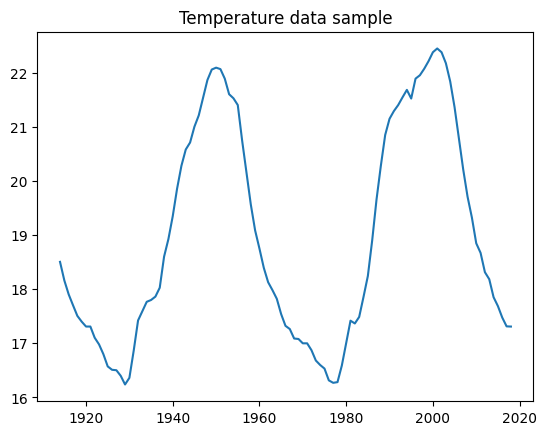

In [10]:
plt.plot(df[20][1500:1600])
plt.title("Temperature data sample")
plt.show()

In [11]:
df.to_csv("../dataset/data_for_occupancy_estimation.csv")

# II - Optimizing Occupancy Estimation through Anomaly Detection

Comparing the performance of a Perceptron model for occupancy estimation trained on anomaly-free data, contaminated data and contaminated data cleaned with our anomaly detector

### 1 - Clean data

In [12]:
from sklearn.model_selection import train_test_split

y = df[14]

# because of resampling and averaging, some values are not binary
y_thres  = 0.1 
y[y <= y_thres] = 0
y[y > y_thres] = 1

X = df.drop(14, axis=1)
X = X.drop(21, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron

for classifier in [DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB(), KNeighborsClassifier(), Perceptron()]:
    print(classifier)

    # Fit the model to the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Print results
    print("Accuracy:", accuracy)
    print("F1_score:", f1score)
    print("Precision:", precision)
    print("Recall:", recall)
    print("\n")

DecisionTreeClassifier()
Accuracy: 0.7325581395348837
F1_score: 0.48406139315230223
Precision: 0.3996101364522417
Recall: 0.6137724550898204


RandomForestClassifier()
Accuracy: 0.8043655650754794
F1_score: 0.5439847836424155
Precision: 0.51952770208901
Recall: 0.5708582834331337


GaussianNB()
Accuracy: 0.795593635250918
F1_score: 0.0
Precision: 0.0
Recall: 0.0


KNeighborsClassifier()
Accuracy: 0.8178294573643411
F1_score: 0.5537231384307847
Precision: 0.5545545545545546
Recall: 0.5528942115768463


Perceptron()
Accuracy: 0.8847409220726234
F1_score: 0.6439823566477632
Precision: 0.8735042735042735
Recall: 0.5099800399201597




C:\Users\maher\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We will use the perceptron as it yields the best performance

### 2 - Contaminated data

In [14]:
# generate anomalies for "data_for_occupancy_estimation.csv" using 

In [15]:
loc_anom = pd.read_csv("../dataset/gen_anomalies/locOuts_data_for_occupancy_estimation.csv")
glob_anom = pd.read_csv("../dataset/gen_anomalies/gloOuts_data_for_occupancy_estimation.csv")

In [16]:
anom_df = pd.concat([loc_anom, glob_anom], axis=0)
anom_df = glob_anom + loc_anom

anom_df.drop('label', axis=1, inplace=True)
anom_df.drop('Unnamed: 0', axis=1, inplace=True)
anom_df.drop('14', axis=1, inplace=True)
anom = anom_df.drop("21", axis=1)
anom

,19,20,22
0,61.777553,44.058458,237213.447085
1,81.858598,33.124689,276871.187080
2,105.325629,33.360760,55290.665322
3,72.906016,34.953564,201804.952162
4,88.985557,42.606510,282991.112931
...,...,...,...
14995,46.930992,22.563051,268467.419080
14996,85.633870,59.209121,119244.116550
14997,45.193067,41.959668,25092.842870
14998,63.183851,28.748758,256723.205828


In [17]:
import random

seed = 19
random.seed(seed)
np.random.seed(seed)

contam_r = 0.05 # contamination rate
n_samples = len(y_train)*contam_r
x_train_contam = X_train.copy()

synth_anom_idx = set()
for _ in range(int(n_samples)):
    i = random.randint(0, len(y_train)-1) # anomaly idx in time serie
    while i in synth_anom_idx:
        i = random.randint(0, len(y_train)-1)
    synth_anom_idx.add(i)
    j = random.randint(0, len(anom_df)-1) # synthesized anomaly idx
    k = random.randint(0, 2) # sensor that contains the anomaly
    x_train_contam.iloc[i].values[k] = anom.iloc[j][k] # use single feat anom instead

In [18]:
# Fit the model to the contaminated training data
classifier.fit(x_train_contam, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)
y_pred_contam = y_pred.copy()
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print results
print("Accuracy:", accuracy)
print("F1_score:", f1score)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6491228070175439
F1_score: 0.4601381042059008
Precision: 0.3356227106227106
Recall: 0.7315369261477046


### 3 - Filtered contaminated data

Generating different univariate data to run the RLNAS framework on and find an adequate anomaly detection architecture

In [19]:
# create anomaly free train, contaminated test from x_train to run RLNAS

categ_to_keep = [19, 20, 22]
for categ in categ_to_keep:
    feat = X_train[categ].copy() # anomaly free data
    anom_feat = anom[f"{categ}"]
    print(categ)

    window_size = 100
    step = 10 

    lb = 0
    hb = window_size
    train_size = len(feat)/window_size*window_size/step*0.8

    train_out = []
    train_gt = []
    test_out = []
    test_gt = []

    i = 0
    while hb<len(feat):
        normal_sample = feat[lb:hb]
        
        if i<train_size:
            train_out.append(normal_sample.values)
            train_gt.append(0)

        else:
            # test data
            normal_sample = feat[lb:hb]
            r = random.random()
            if r<0.2:
                ts = normal_sample.copy()
                anom_t = random.randint(int(0.25*window_size), int(0.75*window_size))

                id = random.randint(0, len(anom_feat)-1)
                ts.values[anom_t] = anom_feat.values[id]
                while not np.abs(ts.mean()-anom_feat.values[id])>0.5:
                    ts = normal_sample.copy()
                    id = random.randint(0, len(anom_feat))
                    ts.values[anom_t] = anom_feat.values[id]

                test_out.append(ts.values)
                test_gt.append(1)
                
            else:
                test_out.append(normal_sample.values)
                test_gt.append(0)

        lb += step 
        hb += step 
        i += 1

    train_out_df = pd.DataFrame(train_out)
    train_out_df["gt"] = train_gt
    train_out_df.to_csv(f"../dataset/synth_ts_data/train_{categ}.csv", index=False)

    test_out_df = pd.DataFrame(test_out)
    test_out_df["gt"] = test_gt
    test_out_df.to_csv(f"../dataset/synth_ts_data/test_{categ}.csv", index=False)

    print(len(train_gt))
    print(len(test_gt))
    

19
1569
382
20
1569
382
22
1569
382


In [20]:
# run RLNAS to find autoencoder architecture for each sensor

Infering the top discovered Autoencoders to filter anomalies from contaminated X_train data

Our method detects that an anomaly exists in a 100 data point sequence, but not the exact anomalous poin. tHowever we need to filter a single data point, otherwise (filtering all detected sequences of size 100), we end up with too few data points. Hence, we a single-point anoamly as the datapoint for which the reconstruction distance is the greatest.

In [21]:
import sys
sys.path.append("C:\\Users\\maher\\RLNAS-for-Anomaly-Detection-in-Time-Series-using-Autoencoders") # temporarily fix imports
from models.autoencoder import AE
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'


class trained_model():
    """Load trained model and infer on input sequence"""
    
    def __init__(self, arch, loss_threshold, save_path):
        self.loaded_model = AE(arch).to(device)
        self.loaded_model.load_state_dict(torch.load(save_path))
        self.loaded_model.eval() 
        self.loss_threshold = loss_threshold
        self.criterion = nn.MSELoss(reduction='mean')

    def infer_model(self, input_sequence):
        sequence = torch.tensor(input_sequence).reshape(1, 1, 100).to(device, dtype=torch.float32)
        original_ts = sequence
        reconstructed_ts = self.loaded_model(original_ts)
        # loss = self.criterion(original_ts, reconstructed_ts)
        loss = torch.max(torch.abs(original_ts - reconstructed_ts))
        max_diff_idx = torch.argmax((original_ts-reconstructed_ts).abs())
        return max_diff_idx, loss>=self.loss_threshold


model_19 = trained_model(arch=[0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 1], loss_threshold=12.129, save_path="../weights/19_[0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 1]_12.129.pt")
model_20 = trained_model(arch=[1, 0, 2, 0, 1, 0, 2, 1, 2, 0, 1, 1], loss_threshold=3.9416, save_path="../weights/20_[1, 0, 2, 0, 1, 0, 2, 1, 2, 0, 1, 1]_3.9416.pt")
model_22 = trained_model(arch=[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 3], loss_threshold=56.601, save_path="../weights/22_[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 3]_56.601.pt")


In [22]:
x_train_contam_clean = x_train_contam.copy()
x_train_contam_clean.reset_index(inplace=True)
x_train_contam_clean.drop('index', axis=1, inplace=True)

y_train_contam_clean = y_train.copy()
y_train_contam_clean = y_train_contam_clean.reset_index()
y_train_contam_clean.drop('index', axis=1, inplace=True)
y_train_contam_clean = y_train_contam_clean[14]

In [23]:
contam_feat_19 = x_train_contam_clean[19]
contam_feat_20 = x_train_contam_clean[20]
contam_feat_22 = x_train_contam_clean[22]

detected_anom_idxs = []
window_size = 100
step = 50 
lb = 0
hb = window_size

while hb<len(contam_feat_19):
    sample_19 = contam_feat_19[lb:hb]
    sample_20 = contam_feat_20[lb:hb]
    sample_22 = contam_feat_22[lb:hb]

    anom_idx_19, is_anom_19 = model_19.infer_model(sample_19.values)
    anom_idx_20, is_anom_20 = model_20.infer_model(sample_20.values)
    anom_idx_22, is_anom_22 = model_22.infer_model(sample_22.values)

    if is_anom_19: detected_anom_idxs.append(lb + anom_idx_19.item())
    if is_anom_20: detected_anom_idxs.append(lb + anom_idx_20.item())
    if is_anom_22: detected_anom_idxs.append(lb + anom_idx_22.item())

    lb += step 
    hb += step 
    
detected_anom_idxs = set(detected_anom_idxs) # repeating idxs because of time window stride and multiple sensors anomalies at same time

tp = 0
for gt_anom in synth_anom_idx:
    if gt_anom in detected_anom_idxs:
        tp += 1
tp

578

In [24]:
print(f"TP={tp}, FP= {len(detected_anom_idxs)-tp}")
print(f"Total real anomalies: {len(synth_anom_idx)}")

TP=578, FP= 191
Total real anomalies: 980


In [25]:
# removing detected anomalies (both TP and FP)
for detect_anom in detected_anom_idxs:
    x_train_contam_clean = x_train_contam_clean.drop(detect_anom)
    y_train_contam_clean = y_train_contam_clean.drop(detect_anom)

Performance of the Occupancy Estimation model trained on the filtered data

In [26]:
# Fit the model to the training data
classifier.fit(x_train_contam_clean, y_train_contam_clean)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print results
print("Accuracy:", accuracy)
print("F1_score:", f1score)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.8843329253365974
F1_score: 0.646288209606987
Precision: 0.8618968386023295
Recall: 0.5169660678642715
